# Fine-Grained Wood Texture Segmentation: Specialized SAM vs. MobileSAM

## Project Goal
Standard SAM (Segment Anything Model) is a powerful generalist, but it often struggles with **fine-grained texture discrimination** (e.g., distinguishing between two very similar wood grain types).

This project aims to:
1.  **Demonstrate the failure cases** of a generalist model (MobileSAM) on a custom "Wood Mosaic" dataset.
2.  **Build a specialized SAM-style decoder** that learns to separate these specific textures better than the baseline.

## Plan
1.  **Setup & Data**: Generate synthetic "mosaics" of wood textures to create hard segmentation boundaries.
2.  **Baseline**: Run MobileSAM (Zero-Shot) with grid prompts to see how it performs.
3.  **Specialization**: Train a lightweight, custom Mask Decoder on top of MobileSAM's image embeddings.
4.  **Comparison**: Compare IoU and visual quality.

In [20]:
# ==== STEP 1: INSTALL DEPENDENCIES ====
# We use MobileSAM for efficiency (running on Colab/Consumer GPU)

try:
    import mobile_sam
    print("MobileSAM already installed.")
except ImportError:
    print("Installing MobileSAM and dependencies...")
    %pip install git+https://github.com/ChaoningZhang/MobileSAM.git
    %pip install timm  # Required for some encoders

import os
import random
import numpy as np
import pandas as pd
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.cluster import KMeans
from torchvision import transforms

# MobileSAM imports
from mobile_sam import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

# Fix Seeds for Reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)

MobileSAM already installed.
Using device: cuda


In [21]:
# ==== STEP 2: PATHS & DOWNLOAD PRETRAINED WEIGHTS ====
# Adjust these paths to match your Colab/Local setup

DATA_DIR = Path('content/wood_data')  # Relative path for portability
IMAGES_DIR = DATA_DIR / 'images' / 'images' # Check your actual structure!
CSV_PATH = DATA_DIR / 'wood.csv'

# Download MobileSAM weights if not present
WEIGHTS_DIR = Path('weights')
WEIGHTS_DIR.mkdir(exist_ok=True)
MOBILESAM_CHECKPOINT = WEIGHTS_DIR / "mobile_sam.pt"

if not MOBILESAM_CHECKPOINT.exists():
    print("Downloading MobileSAM weights...")
    !wget -P weights https://github.com/ChaoningZhang/MobileSAM/raw/master/weights/mobile_sam.pt

print(f"Images Directory: {IMAGES_DIR}")
print(f"Weights Path: {MOBILESAM_CHECKPOINT}")

Images Directory: content/wood_data/images/images
Weights Path: weights/mobile_sam.pt


In [22]:
# ==== STEP 3: DATA PREPARATION & MOSAIC GENERATION ====
# Goal: Create synthetic training images where multiple wood textures meet.
# This forces the model to learn fine-grained boundaries.

# 3.1 Load Metadata
# FIX: Ensure DATA_DIR and CSV_PATH are correctly set to the absolute path in Colab.
# Assuming files are in /content/wood_data.
DATA_DIR = Path('/content/wood_data')
IMAGES_DIR = DATA_DIR / 'images' # Redefine IMAGES_DIR based on the corrected DATA_DIR
CSV_PATH = DATA_DIR / 'wood.csv'

if not CSV_PATH.exists():
    raise FileNotFoundError(f"CSV file not found at {CSV_PATH}. Please check paths.")

df = pd.read_csv(CSV_PATH)
# Ensure image paths are correct
df['image_path'] = df['image'].apply(lambda x: str(IMAGES_DIR / x))
valid_images = df[df['image_path'].apply(os.path.exists)]
print(f"Found {len(valid_images)} valid images out of {len(df)} entries.")
df = valid_images.reset_index(drop=True)

# 3.2 Visual Clustering (Simplified for Speed)
# We use a small ResNet/ViT to cluster textures so we can stitch *different* textures together.
import timm

def get_image_embeddings(dataframe, encoder_name='resnet18', image_size=224):
    print(f"Extracting features using {encoder_name}...")
    encoder = timm.create_model(encoder_name, pretrained=True, num_classes=0).to(DEVICE)
    encoder.eval()

    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    features = []
    for idx, row in dataframe.iterrows():
        img = Image.open(row['image_path']).convert('RGB')
        input_tensor = transform(img).unsqueeze(0).to(DEVICE)
        with torch.no_grad():
            feat = encoder(input_tensor).squeeze().cpu().numpy()
        features.append(feat)
    return np.array(features)

# Extract & Cluster
N_CLUSTERS = 5
feats = get_image_embeddings(df)
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=RANDOM_SEED, n_init=10)
df['cluster_id'] = kmeans.fit_predict(feats)
print("Texture Clusters:", df['cluster_id'].value_counts())

Found 530 valid images out of 530 entries.
Extracting features using resnet18...
Texture Clusters: cluster_id
1    183
0    171
2     96
4     41
3     39
Name: count, dtype: int64


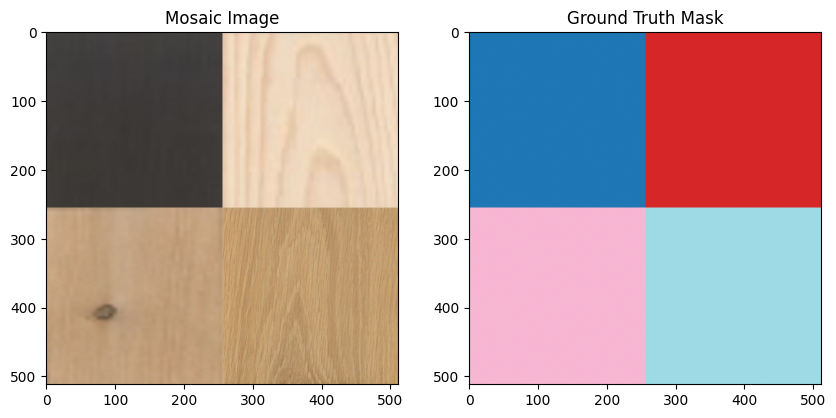

In [23]:
# ==== STEP 4: MOSAIC DATASET GENERATION ====
# We create 2x2 or 3x3 grids.
# CRITICAL: We record the center point of each tile to use as a SAM Prompt.

TILE_SIZE = 256  # Size of each wood patch
GRID_ROWS, GRID_COLS = 2, 2  # 2x2 Grid = 4 textures per image
MOSAIC_SIZE = TILE_SIZE * GRID_ROWS

def create_mosaic(df, rows=2, cols=2, tile_size=256, similar_pairs_only=False):
    h = rows * tile_size
    w = cols * tile_size

    mosaic_img = Image.new('RGB', (w, h))
    mask = np.zeros((h, w), dtype=np.int32)

    prompts = [] # List of (x, y, label)

    # Hard Mode Logic: Pick one cluster ID and sample mostly from it
    target_cluster = None
    if similar_pairs_only:
        target_cluster = random.choice(df['cluster_id'].unique())
        cluster_subset = df[df['cluster_id'] == target_cluster]
        # If cluster too small, fallback to full df
        if len(cluster_subset) < rows*cols:
            sample = df.sample(rows * cols)
        else:
            sample = cluster_subset.sample(rows * cols)
    else:
        sample = df.sample(rows * cols)

    idx = 0
    for r in range(rows):
        for c in range(cols):
            row_data = sample.iloc[idx]
            img_path = row_data['image_path']
            cluster_id = row_data['cluster_id']

            patch = Image.open(img_path).convert('RGB').resize((tile_size, tile_size))

            y_start, x_start = r * tile_size, c * tile_size
            mosaic_img.paste(patch, (x_start, y_start))

            # Fill mask
            mask[y_start:y_start+tile_size, x_start:x_start+tile_size] = idx + 1 # Instance ID (1-based)

            # Calculate Prompt (Center of tile)
            center_x = x_start + tile_size // 2
            center_y = y_start + tile_size // 2
            prompts.append({'point': [center_x, center_y], 'label': 1, 'id': idx+1})

            idx += 1

    return mosaic_img, mask, prompts

# Visualize one
mosaic, mask, prompts = create_mosaic(df)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1); plt.imshow(mosaic); plt.title("Mosaic Image")
plt.subplot(1, 2, 2); plt.imshow(mask, cmap='tab20'); plt.title("Ground Truth Mask")
plt.show()

Running Zero-Shot Baseline on a sample...


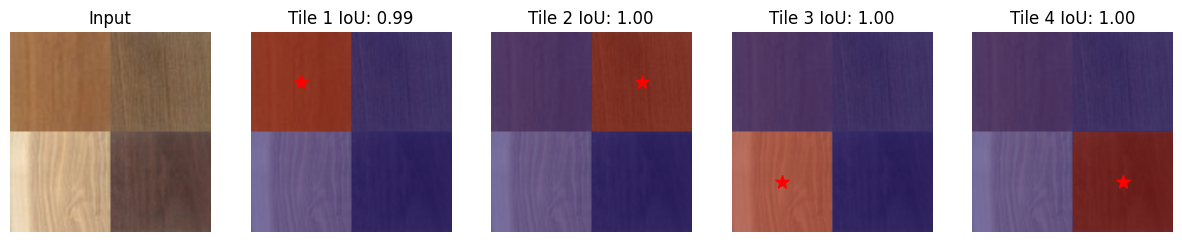

Average Baseline IoU for this image: 0.9950


In [24]:
# ==== STEP 5: BASELINE EVALUATION (Zero-Shot MobileSAM) ====
# We will give MobileSAM the *perfect center point* of each tile.
# If it's a good generalist, it should segment the square tile perfectly.
# If it fails, it will likely over-segment (texture details) or under-segment (merge similar woods).

# Load Model
mobile_sam = sam_model_registry['vit_t'](checkpoint=MOBILESAM_CHECKPOINT)
mobile_sam.to(DEVICE)
mobile_sam.eval()
predictor = SamPredictor(mobile_sam)

def eval_baseline_single_image(mosaic, mask_gt, prompts, predictor):
    mosaic_np = np.array(mosaic)
    predictor.set_image(mosaic_np)

    ious = []

    fig, axes = plt.subplots(1, len(prompts) + 1, figsize=(15, 3))
    axes[0].imshow(mosaic)
    axes[0].set_title("Input")
    axes[0].axis('off')

    for i, p in enumerate(prompts):
        # Prepare Point Prompt: shape (1, 2), label (1,)
        input_point = np.array([p['point']])
        input_label = np.array([1])

        masks, scores, logits = predictor.predict(
            point_coords=input_point,
            point_labels=input_label,
            multimask_output=False # We want the best single mask
        )

        pred_mask = masks[0]

        # Calculate IoU against the specific tile GT
        gt_mask_binary = (mask_gt == p['id'])
        intersection = np.logical_and(pred_mask, gt_mask_binary).sum()
        union = np.logical_or(pred_mask, gt_mask_binary).sum()
        iou = intersection / union if union > 0 else 0
        ious.append(iou)

        # Visualize
        axes[i+1].imshow(mosaic)
        axes[i+1].imshow(pred_mask, alpha=0.5, cmap='jet')
        axes[i+1].scatter(input_point[0,0], input_point[0,1], c='red', marker='*', s=100)
        axes[i+1].set_title(f"Tile {i+1} IoU: {iou:.2f}")
        axes[i+1].axis('off')

    plt.show()
    return np.mean(ious)

# Run Baseline Test
print("Running Zero-Shot Baseline on a sample...")
mosaic, mask_gt, prompts = create_mosaic(df)
avg_iou = eval_baseline_single_image(mosaic, mask_gt, prompts, predictor)
print(f"Average Baseline IoU for this image: {avg_iou:.4f}")

In [25]:
# ==== STEP 6: PRE-COMPUTATION FOR FAST TRAINING ====
# Training with the full Image Encoder every step is slow and memory heavy.
# We will pre-compute the 256x64x64 embeddings for our training mosaics.

N_TRAIN = 500  # Number of training mosaics
EMBED_DIR = Path('wood_embeddings')
EMBED_DIR.mkdir(exist_ok=True)

def precompute_embeddings(df, n_samples=100, save_dir=EMBED_DIR):
    print(f"Pre-computing embeddings for {n_samples} mosaics...")
    metadata = []

    for i in range(n_samples):
        mosaic, mask, prompts = create_mosaic(df)

        # Run Image Encoder
        predictor.set_image(np.array(mosaic))
        embedding = predictor.get_image_embedding().cpu().numpy() # Shape (1, 256, 64, 64)

        # Save to disk
        embed_path = save_dir / f"embed_{i:04d}.npy"
        mask_path = save_dir / f"mask_{i:04d}.npy"

        np.save(embed_path, embedding)
        np.save(mask_path, mask)

        # Store prompt metadata
        metadata.append({
            'id': i,
            'embed_path': str(embed_path),
            'mask_path': str(mask_path),
            'prompts': prompts
        })

        if (i+1) % 50 == 0: print(f"Processed {i+1}/{n_samples}")

    return pd.DataFrame(metadata)

train_meta = precompute_embeddings(df, n_samples=N_TRAIN)
train_meta.to_csv('train_meta.csv', index=False)

Pre-computing embeddings for 500 mosaics...
Processed 50/500
Processed 100/500
Processed 150/500
Processed 200/500
Processed 250/500
Processed 300/500
Processed 350/500
Processed 400/500
Processed 450/500
Processed 500/500


In [26]:
# ==== STEP 7: SPECIALIZED SAM DECODER ====
# We define a Dataset that loads the pre-computed embeddings and prompts.
# Then we define a training loop that fine-tunes the Mask Decoder.

class WoodEmbeddingDataset(Dataset):
    def __init__(self, metadata_df):
        self.meta = metadata_df

    def __len__(self):
        return len(self.meta)

    def __getitem__(self, idx):
        row = self.meta.iloc[idx]

        # Load Embedding (1, 256, 64, 64)
        embedding = np.load(row['embed_path'])
        embedding = torch.from_numpy(embedding).to(DEVICE)

        # Load GT Mask
        full_mask = np.load(row['mask_path'])

        # Select ONE random prompt to train on this step
        # (Training on all prompts at once is possible but single is simpler for batching)
        import ast
        prompts = row['prompts']
        if isinstance(prompts, str): prompts = ast.literal_eval(prompts)

        p = random.choice(prompts)

        # Prepare Point (Batch Size 1 logic handled in collate or manually)
        point_coords = torch.tensor([p['point']], dtype=torch.float32).to(DEVICE) # (1, 2)
        point_labels = torch.tensor([1], dtype=torch.int64).to(DEVICE)           # (1,)

        # Prepare GT Binary Mask for this prompt
        gt_binary = (full_mask == p['id']).astype(np.float32)
        gt_binary = torch.from_numpy(gt_binary).unsqueeze(0).to(DEVICE) # (1, H, W)

        return embedding, point_coords, point_labels, gt_binary

train_dataset = WoodEmbeddingDataset(train_meta)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True) # Batch size 1 for simplicity with variable prompts

In [27]:
# ==== STEP 8: TRAINING LOOP ====
# We freeze everything except the mask decoder.

model = sam_model_registry['vit_t'](checkpoint=MOBILESAM_CHECKPOINT)
model.to(DEVICE)
model.train()

# FREEZE Image Encoder & Prompt Encoder
for param in model.image_encoder.parameters():
    param.requires_grad = False
for param in model.prompt_encoder.parameters():
    param.requires_grad = False

# Only Mask Decoder is trainable
optimizer = torch.optim.AdamW(model.mask_decoder.parameters(), lr=1e-4, weight_decay=1e-4)
loss_fn = torch.nn.MSELoss() # Simple MSE for mask IoU prediction + BCE/Dice for mask

def dice_loss(pred, target, smooth=1.):
    pred = torch.sigmoid(pred)
    pred = pred.view(-1)
    target = target.view(-1)
    intersection = (pred * target).sum()
    return 1 - ((2. * intersection + smooth) / (pred.sum() + target.sum() + smooth))

# Train
EPOCHS = 5
for epoch in range(EPOCHS):
    total_loss = 0
    for i, (emb, coords, labels, gt_mask) in enumerate(train_loader):
        # coords: (B, 1, 2), labels: (B, 1)
        # We need to reshape for SAM: (B, N_points, 2)
        coords = coords.unsqueeze(1) # (B, 1, 1, 2) -> wait, loader gives (1, 1, 2) already if batch=1
        # Correct shape for SAM prompt encoder: (B, points_per_image, 2)
        coords = coords.view(1, 1, 2)
        labels = labels.view(1, 1)

        # 1. Embed Prompts
        with torch.no_grad():
            sparse_embeddings, dense_embeddings = model.prompt_encoder(
                points=(coords, labels),
                boxes=None,
                masks=None,
            )

        # --- DIAGNOSTIC PRINTS START ---
        # print(f"Epoch {epoch+1}, Batch {i+1}:")
        # print(f"  emb.shape: {emb.shape}")
        # print(f"  sparse_embeddings.shape: {sparse_embeddings.shape}")
        # print(f"  dense_embeddings.shape: {dense_embeddings.shape}")
        # print(f"  model.prompt_encoder.get_dense_pe().shape: {model.prompt_encoder.get_dense_pe().shape}")
        # --- DIAGNOSTIC PRINTS END ---

        # FIX: Squeeze the extra dimension from emb (Batch_size, 1, C, H, W) -> (Batch_size, C, H, W)
        emb = emb.squeeze(1)

        # 2. Decode Mask (using precomputed image embedding)
        # MobileSAM mask_decoder forward signature:
        # image_embeddings, image_pe, sparse_prompt_embeddings, dense_prompt_embeddings, multimask_output

        low_res_masks, iou_predictions = model.mask_decoder(
            image_embeddings=emb, # (B, 256, 64, 64)
            image_pe=model.prompt_encoder.get_dense_pe(),
            sparse_prompt_embeddings=sparse_embeddings,
            dense_prompt_embeddings=dense_embeddings,
            multimask_output=False,
        )

        # 3. Upscale Mask to Original Size (1024x1024 typically, but here our mosaic size)
        # We need to interpolate low_res_masks (256x256) to GT size (Mosaic Size)
        upscaled_masks = F.interpolate(
            low_res_masks,
            size=(gt_mask.shape[2], gt_mask.shape[3]),
            mode="bilinear",
            align_corners=False,
        )

        # 4. Calc Loss
        loss = dice_loss(upscaled_masks, gt_mask)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {total_loss/len(train_loader):.4f}")

# Save Specialized Model
torch.save(model.mask_decoder.state_dict(), "wood_specialized_decoder.pth")
print("Training Complete. Decoder Saved.")

Epoch 1/5 | Loss: 0.1570
Epoch 2/5 | Loss: 0.0125
Epoch 3/5 | Loss: 0.0426
Epoch 4/5 | Loss: 0.0002
Epoch 5/5 | Loss: 0.0001
Training Complete. Decoder Saved.


Visual Comparison...


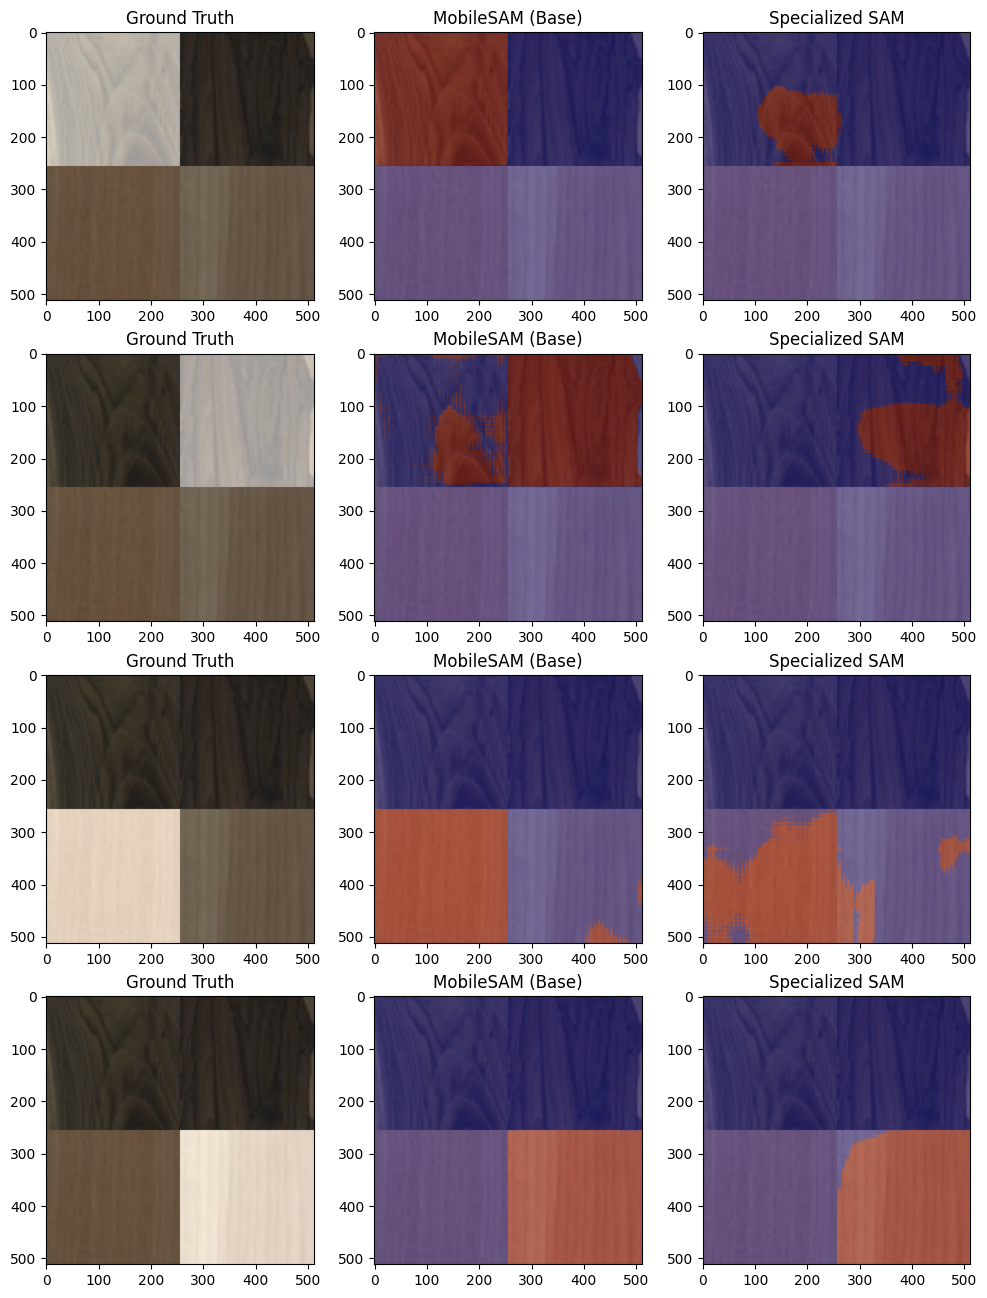

In [28]:
# ==== STEP 9: COMPARISON ====
# Compare Base SAM vs. Specialized SAM on a Test Image

# Load Weights
specialized_model = sam_model_registry['vit_t'](checkpoint=MOBILESAM_CHECKPOINT)
specialized_model.mask_decoder.load_state_dict(torch.load("wood_specialized_decoder.pth"))
specialized_model.to(DEVICE)
specialized_model.eval()

def compare_models(mosaic, mask_gt, prompts):
    # Base Prediction
    base_predictor = SamPredictor(mobile_sam)
    base_predictor.set_image(np.array(mosaic))

    # Specialized Prediction
    spec_predictor = SamPredictor(specialized_model)
    spec_predictor.set_image(np.array(mosaic))

    fig, axes = plt.subplots(len(prompts), 3, figsize=(12, 4*len(prompts)))

    for i, p in enumerate(prompts):
        input_point = np.array([p['point']])
        input_label = np.array([1])

        # Base
        masks_b, _, _ = base_predictor.predict(point_coords=input_point, point_labels=input_label, multimask_output=False)

        # Specialized
        masks_s, _, _ = spec_predictor.predict(point_coords=input_point, point_labels=input_label, multimask_output=False)

        # GT
        gt_mask_binary = (mask_gt == p['id'])

        # Plot
        if len(prompts) == 1:
            ax_row = axes
        else:
            ax_row = axes[i]

        ax_row[0].imshow(mosaic)
        ax_row[0].imshow(gt_mask_binary, alpha=0.5, cmap='gray')
        ax_row[0].set_title("Ground Truth")

        ax_row[1].imshow(mosaic)
        ax_row[1].imshow(masks_b[0], alpha=0.5, cmap='jet')
        ax_row[1].set_title("MobileSAM (Base)")

        ax_row[2].imshow(mosaic)
        ax_row[2].imshow(masks_s[0], alpha=0.5, cmap='jet')
        ax_row[2].set_title("Specialized SAM")

    plt.show()

print("Visual Comparison...")
mosaic, mask_gt, prompts = create_mosaic(df)
compare_models(mosaic, mask_gt, prompts)

In [29]:
# ==== STEP 10: HARD MODE EVALUATION ====
# Evaluation only on mosaics where ALL tiles are from the same texture cluster

def calculate_miou(model_predictor, df, n_test=50, name="Model", hard_mode=False):
    ious = []
    areas = []
    mode_str = "HARD MODE" if hard_mode else "Standard"
    print(f"[{name} - {mode_str}] Calculating mIoU on {n_test} samples...")

    for i in range(n_test):
        mosaic, mask_gt, prompts = create_mosaic(df, similar_pairs_only=hard_mode)
        mosaic_np = np.array(mosaic)
        model_predictor.set_image(mosaic_np)

        for p in prompts:
            input_point = np.array([p['point']])
            input_label = np.array([1])

            masks, _, _ = model_predictor.predict(
                point_coords=input_point,
                point_labels=input_label,
                multimask_output=False
            )

            # Ensure boolean mask
            pred_mask = masks[0] > 0.0

            # GT (Ensure strictly boolean)
            gt_mask_binary = (mask_gt == p['id'])

            # Calculate metrics
            intersection = np.logical_and(pred_mask, gt_mask_binary).sum()
            union = np.logical_or(pred_mask, gt_mask_binary).sum()

            iou = intersection / union if union > 0 else 0.0
            ious.append(iou)

            # Track predicted area percentage
            total_pixels = pred_mask.shape[0] * pred_mask.shape[1]
            pred_area_pct = pred_mask.sum() / total_pixels
            areas.append(pred_area_pct)

    avg_iou = np.mean(ious)
    avg_area = np.mean(areas)
    print(f"[{name}] Avg IoU: {avg_iou:.4f} | Avg Mask Area: {avg_area:.2%}")
    return avg_iou

# Setup Predictors
base_model_fresh = sam_model_registry['vit_t'](checkpoint=MOBILESAM_CHECKPOINT)
base_model_fresh.to(DEVICE)
base_model_fresh.eval()
base_predictor = SamPredictor(base_model_fresh)

spec_predictor = SamPredictor(specialized_model)

# Run Eval - HARD MODE
print("--- Starting Hard Mode Evaluation --- (Samples from same texture family)")
base_miou = calculate_miou(base_predictor, df, n_test=50, name="Base", hard_mode=True)
spec_miou = calculate_miou(spec_predictor, df, n_test=50, name="Specialized", hard_mode=True)

print(f"\nHard Mode Results:")
print(f"MobileSAM Base mIoU: {base_miou:.4f}")
print(f"Specialized SAM mIoU: {spec_miou:.4f}")
print(f"Improvement: +{(spec_miou - base_miou)*100:.2f}%")

--- Starting Hard Mode Evaluation --- (Samples from same texture family)
[Base - HARD MODE] Calculating mIoU on 50 samples...
[Base] Avg IoU: 0.9580 | Avg Mask Area: 24.39%
[Specialized - HARD MODE] Calculating mIoU on 50 samples...
[Specialized] Avg IoU: 0.5952 | Avg Mask Area: 16.61%

Hard Mode Results:
MobileSAM Base mIoU: 0.9580
Specialized SAM mIoU: 0.5952
Improvement: +-36.28%
